## Primer 2
### Online SVM klasifikator

Na ovom primeru pokazaćemo kako se može trenirati online klasifikator korišćenjem klase [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.partial_fit). Uporedićemo performanse modela dobijene u sledeća 2 slučaja:
1. obrađivanje kompletnog skupa podataka odjednom (batch/offline setting)
2. obrađivanje podskupa podataka sekvencijalno (online setting)
                                                                                                        
Koristićemo [Run or Walk](https://www.kaggle.com/datasets/vmalyi/run-or-walk) skup podataka koji se sastoji od vrednosti senzornih parametara koji opisuju iPhone kada osoba hoda ili trči. 

In [1]:
import numpy as np 
import pandas as pd
import time
import matplotlib.pyplot as plt
import pickle
from datetime import time

In [2]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [3]:
# učitavamo podatke i prikazujemo dimenzije
df = pd.read_csv("dataset.csv")
df.shape

(88588, 11)

In [4]:
df.head()

,date,time,username,wrist,activity,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z
0,2017-6-30,13:51:15:847724020,viktor,0,0,0.2650,-0.7814,-0.0076,-0.0590,0.0325,-2.9296
1,2017-6-30,13:51:16:246945023,viktor,0,0,0.6722,-1.1233,-0.2344,-0.1757,0.0208,0.1269
2,2017-6-30,13:51:16:446233987,viktor,0,0,0.4399,-1.4817,0.0722,-0.9105,0.1063,-2.4367
3,2017-6-30,13:51:16:646117985,viktor,0,0,0.3031,-0.8125,0.0888,0.1199,-0.4099,-2.9336
4,2017-6-30,13:51:16:846738994,viktor,0,0,0.4814,-0.9312,0.0359,0.0527,0.4379,2.4922


In [5]:
# odbacujemo kolone sa nepotrebnim podacima i prikazujemo deskriptivne statistike
df = df.drop(["date", "time", "username"], axis=1)
df.describe()

,wrist,activity,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z
count,88588.000000,88588.000000,88588.000000,88588.000000,88588.000000,88588.000000,88588.000000,88588.000000
mean,0.522170,0.500801,-0.074811,-0.562585,-0.313956,0.004160,0.037203,0.022327
std,0.499511,0.500002,1.009299,0.658458,0.486815,1.253423,1.198725,1.914423
min,0.000000,0.000000,-5.350500,-3.299000,-3.753800,-4.430600,-7.464700,-9.480000
25%,0.000000,0.000000,-0.381800,-1.033500,-0.376000,-0.920700,-0.644825,-1.345125
50%,1.000000,1.000000,-0.059500,-0.759100,-0.221000,0.018700,0.039300,0.006900
75%,1.000000,1.000000,0.355500,-0.241775,-0.085900,0.888800,0.733700,1.398200
max,1.000000,1.000000,5.603300,2.668000,1.640300,4.874200,8.498000,11.266200


In [6]:
data = df.values
X = data[:, 1:]
y = data[:, 0]

Sada definišemo model. Promenljiva `firstRun` pokazuje da li treniramo model u batch ili online režimu, a promenljivom `model` se prenosi prethodno istrenirani model u online režimu.

In [7]:
def svmClassifier(scaledData_X, scaledData_Y, firstRun=0, model=None):
    try:
        np.random.seed(3)
        xTrain = scaledData_X
        yTrain = scaledData_Y

        if yTrain.shape[0] != 1:
            yTrain = yTrain.reshape(-1,1)

        xShape = xTrain.shape
        yShape = yTrain.shape

        # proveravamo da li je potrebno kreirati model ili samo ažurirati prethodni
        if(firstRun==1):
            model = SGDClassifier(
                loss="hinge", penalty="l2", alpha=0.0001, max_iter=3000, tol=None, shuffle=True, verbose=0,
                learning_rate='adaptive', eta0=0.01, early_stopping=False
            )
            
            # predloženi broj iteracija da bi se postigla konvergencija
            model.n_iter = np.ceil(10**6 / len(scaledData_Y))
            
            # treniramo model
            model.fit(xTrain, yTrain)
        else:
            # kako metod partial_fit radi radi za jednu epohu, prolazimo kroz sve instance
            for _ in range(3):
                for i in range(xShape[0]):
                    x = xTrain[i].reshape(1, -1)
                    model.partial_fit(x, yTrain[i])
            
        
        print('Done Training')
        message = "Successfully trained SVMClassifier"

    except Exception as e:
        message = e
        model = {}

    return message, model

Pogledajmo kako se model ponaša u prvom slučaju tj. kada dobija sve podatke odjednom.

In [8]:
# delimo skup podataka na skup za treniranje i testiranje, a zatim skaliramo podatke
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# treniramo model i proveravamo tačnost
message, model = svmClassifier(X_train, y_train, 1); print(message)

total_accuracy = accuracy_score(y_test, model.predict(X_test))
total_f1_score = f1_score(y_test, model.predict(X_test), average='weighted')
print("accuracy: {}".format(total_accuracy))
print("f1 score: {}".format(total_f1_score))

C:\Users\bonum\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Done Training
Successfully trained SVMClassifier
accuracy: 0.9052241838623741
f1 score: 0.9052898189613683


Pređimo sada na drugi slučaj tj. na online režim. Najpre ćemo podeliti skup podataka na 4 dela.

In [9]:
X_split = np.array_split(X, 4)
y_split = np.array_split(y, 4)
scaler = StandardScaler()

# ovde čuvamo tačnost modela
accuracy = []
f1 = []

In [10]:
np.array(X_split).shape

(4, 22147, 7)

In [11]:
np.array(y_split).shape

(4, 22147)

In [12]:
# prvi prolaz, kreiramo model
X_train, X_test, y_train, y_test = train_test_split(X_split[0], y_split[0], test_size=0.25, random_state=999)

# skaliramo podatke
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

message, model = svmClassifier(X_train, y_train, 1); print(message)

accuracy.append(accuracy_score(y_test, model.predict(X_test)))
f1.append(f1_score(y_test, model.predict(X_test), average='weighted'))
print("accuracy: {}".format(accuracy[0]))
print("f1 score: {}".format(f1[0]))

# čuvamo model za dalje ažuriranje
modelSaveFile = 'model_data_id.sav'
pickle.dump(model, open(modelSaveFile, 'wb'))

C:\Users\bonum\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Done Training
Successfully trained SVMClassifier
accuracy: 0.9398591294925049
f1 score: 0.9375183630676401


In [13]:
# drugi prolaz, ažuriramo model
X_train, X_test, y_train, y_test = train_test_split(X_split[1], y_split[1], test_size=0.25, random_state=999)

# učitavamo prethodni model
model = pickle.load(open(modelSaveFile, 'rb'))

# skaliramo podatke
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

message, model = svmClassifier(X_train, y_train, 0, model); print(message)

accuracy.append(accuracy_score(y_test, model.predict(X_test)))
f1.append(f1_score(y_test, model.predict(X_test), average='weighted'))
print("accuracy: {}".format(accuracy[1]))
print("f1 score: {}".format(f1[1]))

# čuvamo model
modelSaveFile = 'model_data_id2.sav'
pickle.dump(model, open(modelSaveFile, 'wb'))

Done Training
Successfully trained SVMClassifier
accuracy: 0.9985551742821023
f1 score: 0.9985683920732263


In [14]:
# treći prolaz, ažuriramo model
X_train, X_test, y_train, y_test = train_test_split(X_split[2], y_split[2], test_size=0.25, random_state=999)

# učitavamo prethodni model
model = pickle.load(open(modelSaveFile, 'rb'))

# skaliramo podatke
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

message, model = svmClassifier(X_train, y_train, 0, model); print(message)

accuracy.append(accuracy_score(y_test, model.predict(X_test)))
f1.append(f1_score(y_test, model.predict(X_test), average='weighted'))
print("accuracy: {}".format(accuracy[2]))
print("f1 score: {}".format(f1[2]))

# čuvamo model
modelSaveFile = 'model_data_id3.sav'
pickle.dump(model, open(modelSaveFile, 'wb'))

Done Training
Successfully trained SVMClassifier
accuracy: 0.8809824814881705
f1 score: 0.8790445700417155


In [15]:
# četvrti prolaz, ažuriramo model
X_train, X_test, y_train, y_test = train_test_split(X_split[3], y_split[3], test_size=0.25, random_state=999)

# učitavamo prethodni model
model = pickle.load(open(modelSaveFile, 'rb'))

# skaliramo podatke
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

message, model = svmClassifier(X_train, y_train, 0, model); print(message)

accuracy.append(accuracy_score(y_test, model.predict(X_test)))
f1.append(f1_score(y_test, model.predict(X_test), average='weighted'))
print("accuracy: {}".format(accuracy[3]))
print("f1 score: {}".format(f1[3]))

# čuvamo model
modelSaveFile = 'model_data_id4.sav'
pickle.dump(model, open(modelSaveFile, 'wb'))

Done Training
Successfully trained SVMClassifier
accuracy: 1.0
f1 score: 1.0


Prikažimo na grafiku dobijene rezultate. Tačnost i f1 score modela koji je istreniran u prvom slučaju predstavljeni su žutom i isprekidanom crvenom linijom, redom.

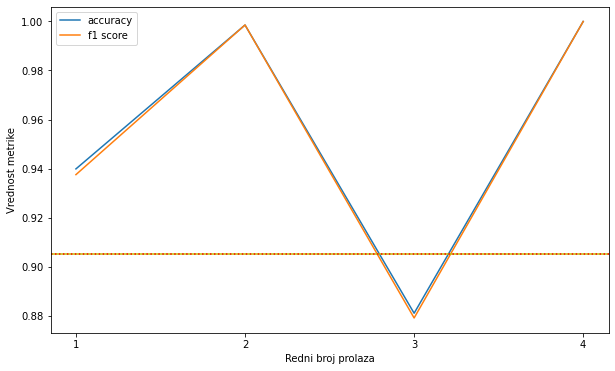

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1,5), np.array(accuracy), label='accuracy')
plt.plot(np.arange(1,5), np.array(f1), label='f1 score')
plt.xticks(np.arange(1,5))
plt.axhline (total_accuracy, color = 'y', linestyle = '-')
plt.axhline (total_f1_score, color = 'r', linestyle = ':')
plt.legend(loc='best')
plt.xlabel("Redni broj prolaza")
plt.ylabel("Vrednost metrike")
plt.show()

Primećujemo da su vrednosti obe metrike modela treniranog u online režimu skoro uvek iznad vrednosti metrika prvog modela treniranog nad svim podacima i da najpre rastu, zatim opadaju i na kraju opet rastu. Ovakvi skokovi i padovi vrednosti metrika nisu iznenađujući jer je primećeno da se to dešava pri korišćenju `partial_fit` metoda. Pri kreiranju modela postavili smo vrednost parametra `learning_rate` na **adaptive** čime se postiže da važi `eta = eta0` sve dok se greške modela smanjuju, a ukoliko se nakon određenog broja epoha model ne poboljša, vrednost parametra se deli sa 5 tj. model brže zaboravlja naučeno. Ovim smo sprečili drastičnije promene, recimo 7.9 -> 98.89 -> 47.7 -> 29.4, ali smo na kraju platili 100% tačnošću, tj. model se potpuno prilagovio podacima.

Izvor: [Online SVM Classifier / SGDClassifier](https://www.kaggle.com/code/prashantdandriyal/online-svm-classifier-sgdclassifier/notebook)